# Modelo LightGBM

Estudiaremos LightGBM, es un algoritmo de refuerzo de gradiantes basado en modelos 
de árboles de decisión

In [31]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import scikitplot as skplt

# Preprocesado y modelado
# ==============================================================================
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve, accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from lightgbm import LGBMClassifier
import multiprocessing
import pickle

# Configuración warnings
# ==============================================================================
import warnings

In [32]:
def evaluate_model(y_test, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(y_test, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(y_test, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(y_test, ypred)))

In [33]:
X_train_lasso = pd.read_parquet("X_train_lasso.parquet")
y_train = pd.read_parquet("y_train.parquet")
X_test_lasso = pd.read_parquet("X_test_lasso.parquet")
y_test = pd.read_parquet("y_test.parquet")

- Ofrecemos al algoritmo distintas variaciones en los hiperparámetros, utilizaremos también la validación cruzada que nos ayudará a seleccionar los más eficientes.
- Luego los muestro en un dataset para luego seleccionar los mejores hipérparámetros de validación cruzada

In [37]:
# Grid de hiperparámetros evaluados
# ============================================================================
param_grid = {'n_estimators'     : [1000], #100, 500
              'max_depth'        : [10], # -1, 1, 3, 5
              'subsample'        : [0.5, 1],
              'learning_rate'    : [ 0.1], #0.001, 0.01
              'boosting_type'    : ['gbdt']
             }

# Búsqueda por grid search con validación cruzada
# =============================================================================
grid = GridSearchCV(
        estimator  = LGBMClassifier(random_state=123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=0), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_lasso, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

C:\Users\pablo\Anaconda3\envs\core_models\lib\site-packages\sklearn\model_selection\_split.py:443: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
C:\Users\pablo\Anaconda3\envs\core_models\lib\site-packages\sklearn\model_selection\_split.py:93: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` 

,param_boosting_type,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
0,gbdt,0.1,10,1000,0.5,-0.384653,0.000258,-0.384416,0.000142
1,gbdt,0.1,10,1000,1,-0.384653,0.000258,-0.384416,0.000142


In [38]:
# Mejores hiperparámetros por validación cruzada
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000, 'subsample': 0.5} : -0.3846534762435812 neg_root_mean_squared_error


In [39]:
# Error de test del modelo final
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test_lasso,)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.38455295663749167


In [34]:
# Cargamos el modelo para no tener que entrenarlo otra vez

with open('LightGBM.pkl', 'rb') as f:
    modelo_final = pickle.load(f)

In [35]:
ypred = modelo_final.predict(X_test_lasso)
ypred_proba = modelo_final.predict_proba(X_test_lasso)

In [36]:
print("Classification report:")
print(classification_report(y_test, ypred))

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92   1440322
           1       0.65      0.24      0.35    288210

    accuracy                           0.85   1728532
   macro avg       0.76      0.61      0.63   1728532
weighted avg       0.83      0.85      0.82   1728532



In [37]:
recall_score(y_test, ypred)

0.24120606502203254

In [38]:
precision_score(y_test, ypred)

0.6531007205734525

### Matriz de confusión

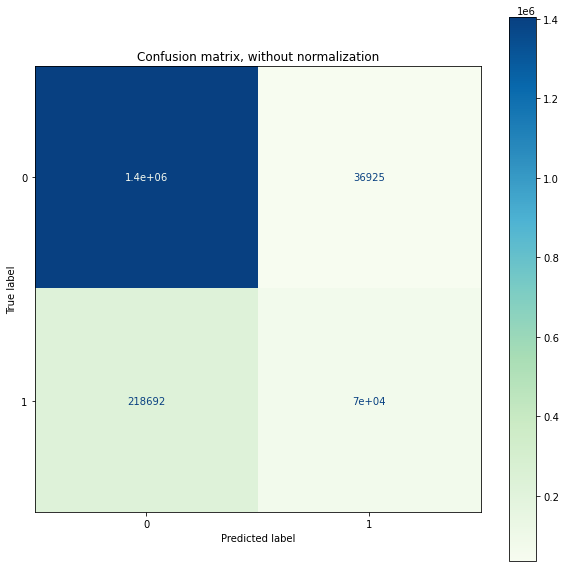

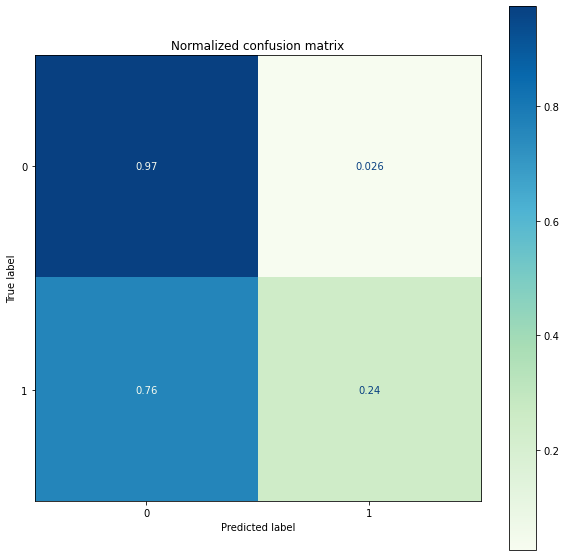

In [39]:
# Matrices de confusiones
titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
        fig, ax = plt.subplots(figsize=(10, 10))
        disp = ConfusionMatrixDisplay.from_predictions(y_test, ypred,
                                                       cmap=plt.cm.GnBu,
                                                       normalize=normalize,
                                                       ax=ax)
        ax.set_title(title)

### Curvas ROC_AUC

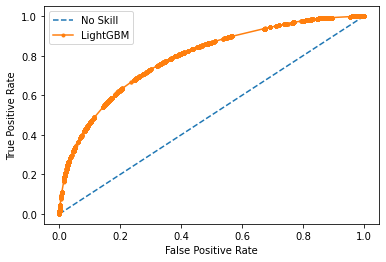

In [42]:
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LightGBM')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [43]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

In [44]:
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.163731, G-Mean=0.716


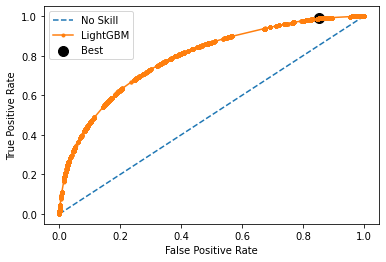

In [51]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LightGBM')
plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [46]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, yhat)

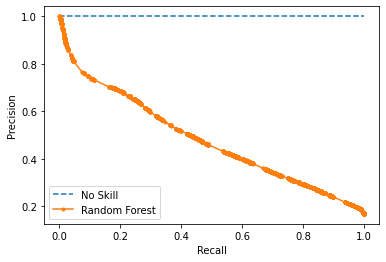

In [47]:
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

Best Threshold=0.244284, F-Score=0.481


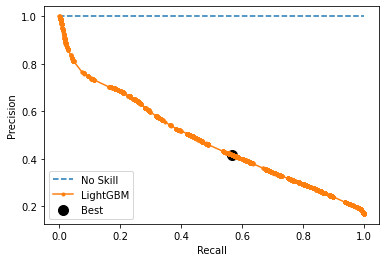

In [48]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='LightGBM')
plt.scatter(recall[ix], precision[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [50]:
# evaluate the model
score = f1_score(y_test, ypred)
print('F-Score: %.5f' % score)

F-Score: 0.35230


In [50]:
evaluate_model(y_test, predicciones, ypred_proba)

ROC-AUC score of the model: 0.7918150504333004
Accuracy of the model: 0.8521190235413634

Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.97      0.92   1440322
           1       0.65      0.24      0.35    288210

    accuracy                           0.85   1728532
   macro avg       0.76      0.61      0.63   1728532
weighted avg       0.83      0.85      0.82   1728532




## Guardamos los resultados del modelo

In [51]:
with open('LightGBM.pkl', 'wb') as f:
    pickle.dump(modelo_final, f)